### Description and purpose of the study

In order to optimize production costs, a metallurgical factory decided to reduce electricity consumption at the steel processing stage. We have to build a model that predicts the temperature of steel.

### Description of the processing stage

Steel is processed in a metal bucket with a capacity of about 100 tons. In order for the bucket to withstand high temperatures, it is lined with refractory bricks from the inside. The molten steel is poured into a ladle and heated to the desired temperature with graphite electrodes. They are installed in the bucket lid.

Sulfur is removed from the alloy (desulfurization), the chemical composition is corrected by adding impurities and samples are taken. Steel is alloyed — its composition is changed — by feeding alloy pieces from a hopper for bulk materials or wire through a special tribe apparatus (English tribe, "mass").

Before the first time alloying additives are introduced, the temperature of the steel is measured and its chemical analysis is performed. Then the temperature is increased for a few minutes, alloying materials are added and the alloy is purged with an inert gas. Then it is mixed and measurements are carried out again. This cycle is repeated until the target chemical composition and optimal melting temperature are reached.

Then the molten steel is sent to the metal finishing or enters the continuous casting machine. From there, the finished product comes out in the form of slabs.

## Data Description

The data consists of files received from different sources:

data_arc_new.csv — data about electrodes;

data_bulk_new.csv — data on the supply of bulk materials (volume);

data_bulk_time_new.csv — data on the supply of bulk materials (time);

data_gas_new.csv — data on gas purging of the alloy;

data_temp_new.csv — temperature measurement results;

data_wire_new.csv — data on wire materials (volume);

data_wire_time_new.csv — data about wire materials (time).

### Work plan

- Data preprocessing. Observation of data types, variables, and data processing.

- Development of functions. Construction of variables of interest to us with special emphasis on variables related to temperature.

- As soon as the data is processed and the variables are processed, we will create a table combining all the columns of interest. We will divide between features and target, which in our case is the temperature.

- We will divide the data set for verification in a ratio of 3:1.

- Prepare all the columns and divide the main functions into target ones.

- We will select a suitable regression model. Among the regressive models that could work well, we consider CatBoost and LightBoost.

- We will evaluate the effectiveness of regression models in order to then choose the best model and submit it to the testing stage. Our goal is to achieve a lower score equal to or less than 6.8.

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostRegressor 
from sklearn.model_selection import cross_val_score 
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor

In [2]:
data_arc = pd.read_csv(r'C:\Users\pinos\Downloads/data_arc_new.csv')
data_bulk = pd.read_csv(r'C:\Users\pinos\Downloads/data_bulk_new.csv')
data_bulk_time = pd.read_csv(r'C:\Users\pinos\Downloads/data_bulk_time_new.csv', index_col=0)
data_gas = pd.read_csv(r'C:\Users\pinos\Downloads/data_gas_new.csv')
data_temp = pd.read_csv(r'C:\Users\pinos\Downloads/data_temp_new.csv')
data_wire = pd.read_csv(r'C:\Users\pinos\Downloads/data_wire_new.csv')
data_wire_time = pd.read_csv(r'C:\Users\pinos\Downloads/data_wire_time_new.csv')

In [3]:
data_arc.head()

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691


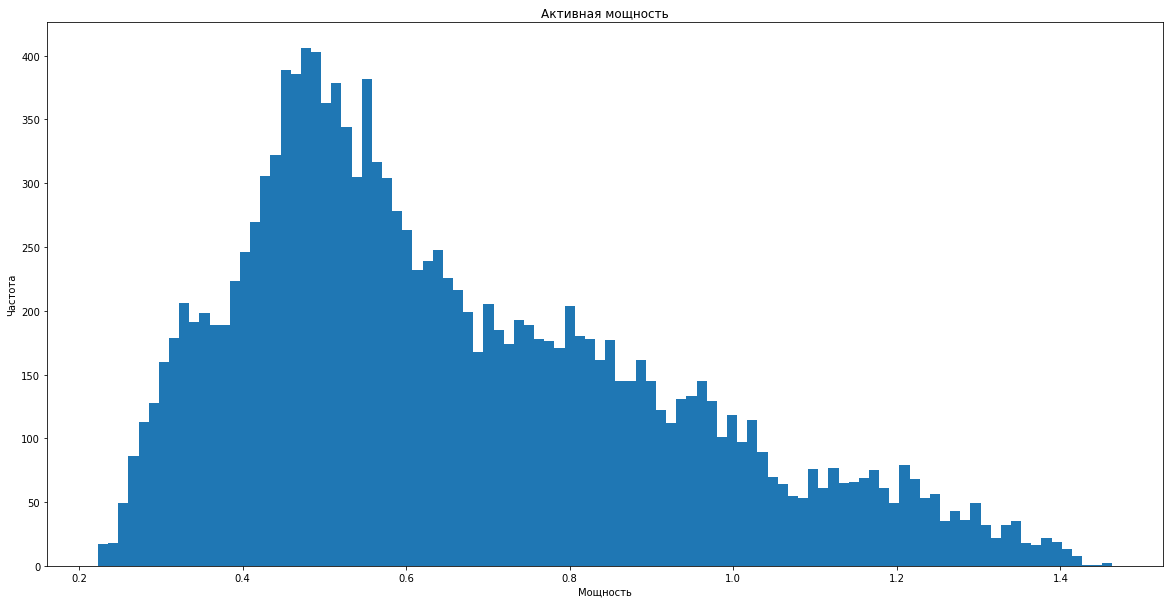

In [4]:
plt.figure(figsize=(20,10))
plt.hist(data_arc['Активная мощность'], bins=100)
plt.title('Активная мощность')
plt.xlabel('Мощность')
plt.ylabel('Частота')
plt.show()

The data in this column looks fine.

In [5]:
data_arc['Активная мощность'].describe()

count    14876.000000
mean         0.662752
std          0.258885
min          0.223120
25%          0.467115
50%          0.599587
75%          0.830070
max          1.463773
Name: Активная мощность, dtype: float64

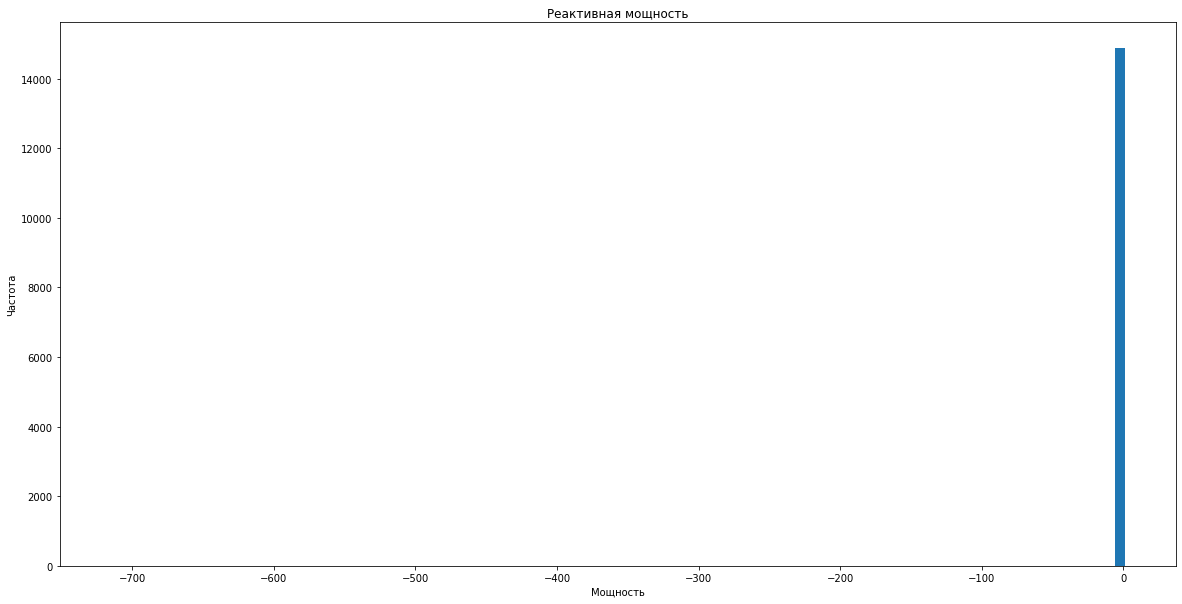

In [6]:
plt.figure(figsize=(20,10))
plt.hist(data_arc['Реактивная мощность'], bins=100)
plt.title('Реактивная мощность')
plt.xlabel('Мощность')
plt.ylabel('Частота')
plt.show()

Something strange is happening here, so we will consider the maximum and minimum.

In [7]:
data_arc['Реактивная мощность'].max()


1.270284

In [8]:
data_arc['Реактивная мощность'].min()

-715.479924

Effectively we will remove atypical values less than 0.

In [9]:
data_arc = data_arc[data_arc['Реактивная мощность'] > 0]

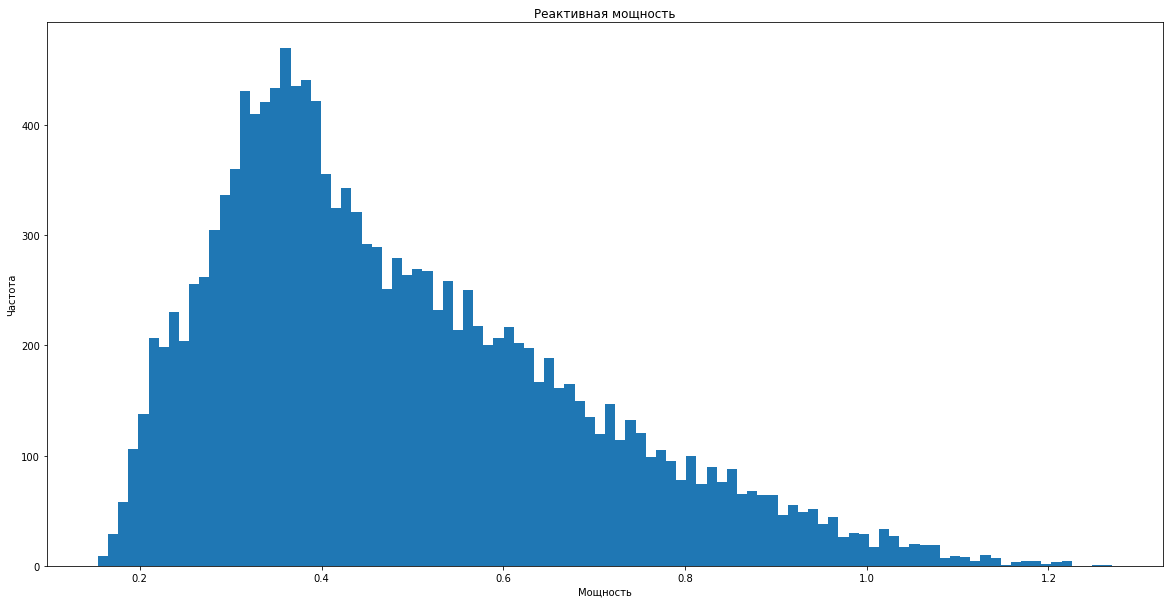

In [10]:
plt.figure(figsize=(20,10))
plt.hist(data_arc['Реактивная мощность'], bins=100)
plt.title('Реактивная мощность')
plt.xlabel('Мощность')
plt.ylabel('Частота')
plt.show()

Now we see the values as normal parameters.

In [11]:
data_arc['Реактивная мощность'].describe()

count    14875.000000
mean         0.487115
std          0.197612
min          0.153777
25%          0.337190
50%          0.441665
75%          0.608223
max          1.270284
Name: Реактивная мощность, dtype: float64

The next thing we're going to do with this dataset is change the time to datetime.

In [12]:
data_arc['Начало нагрева дугой'] = pd.to_datetime(data_arc['Начало нагрева дугой'] )

In [13]:
data_arc['Конец нагрева дугой'] = pd.to_datetime(data_arc['Конец нагрева дугой'] )

In [14]:
data_arc['electrode_duration'] = data_arc.groupby('key')['Конец нагрева дугой'].max() - data_arc.groupby('key')['Начало нагрева дугой'].min()

In [15]:
# We check that the changes were made correctly
data_arc.head()

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,electrode_duration
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253,NaT
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438,0 days 00:26:23
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460,0 days 00:19:04
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979,0 days 00:25:25
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691,0 days 00:18:13


### Conclusion

In this first data set, we find the heating time, both initial and final, in addition to its active and reactive power. The active power values are distributed between 0.25 and 1.4, while most of the data is distributed between 0.3 and 1. The reactive power has values from about 0.1 to 1.2, while the bulk of the data is distributed between 0.3 and 0.6. We also remove static values less than zero.

In [16]:
data_bulk = pd.read_csv(r'/datasets/data_bulk_new.csv')

In [17]:
data_bulk.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


In [18]:
data_bulk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


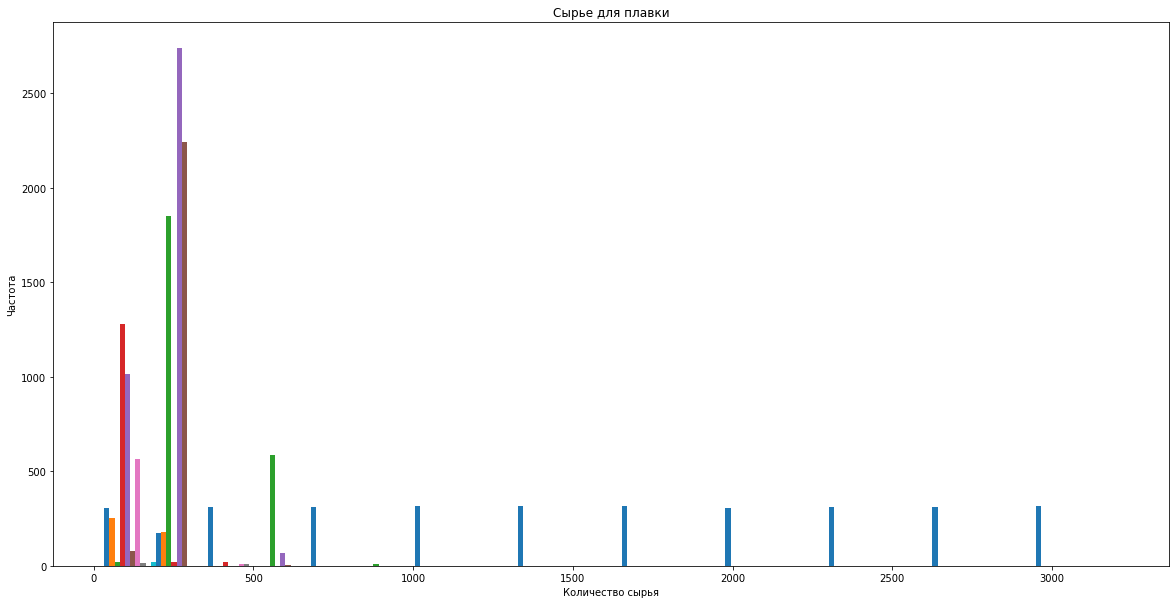

In [19]:
plt.figure(figsize=(20,10))
plt.hist(data_bulk)
plt.title('Сырье для плавки')
plt.xlabel('Количество сырья')
plt.ylabel('Частота')
plt.show()

We are running a loop to see the variables and their visual representation more clearly.

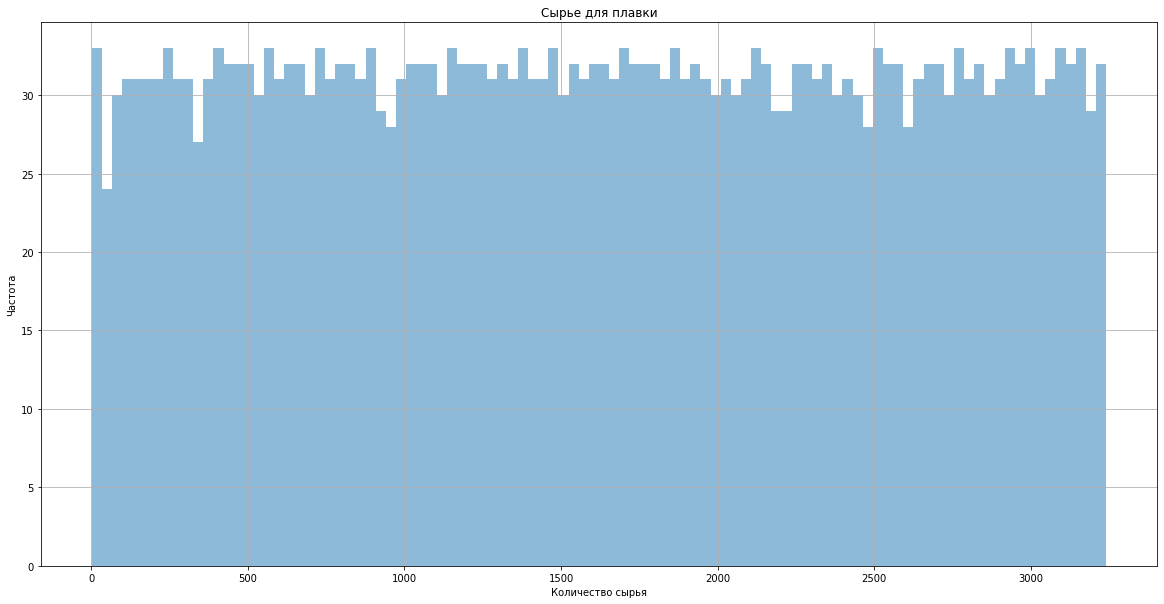

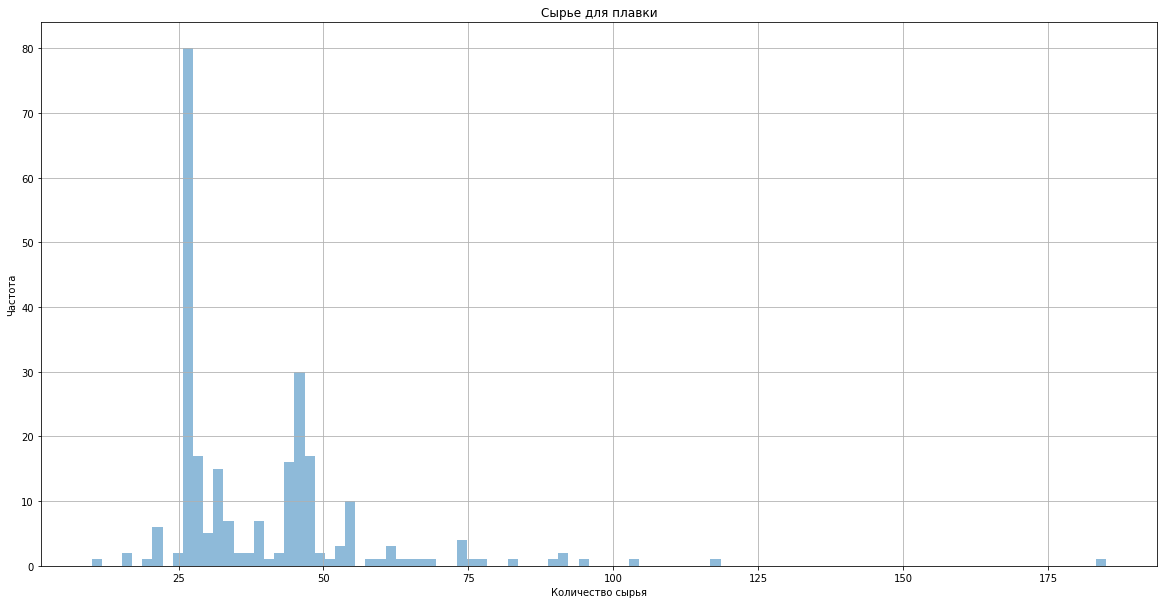

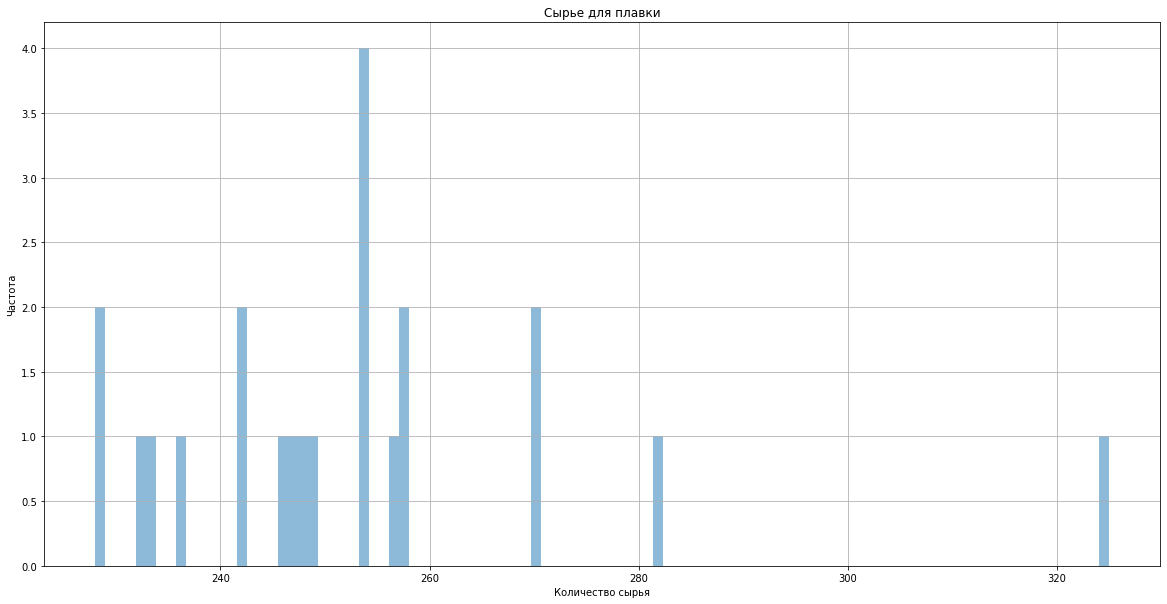

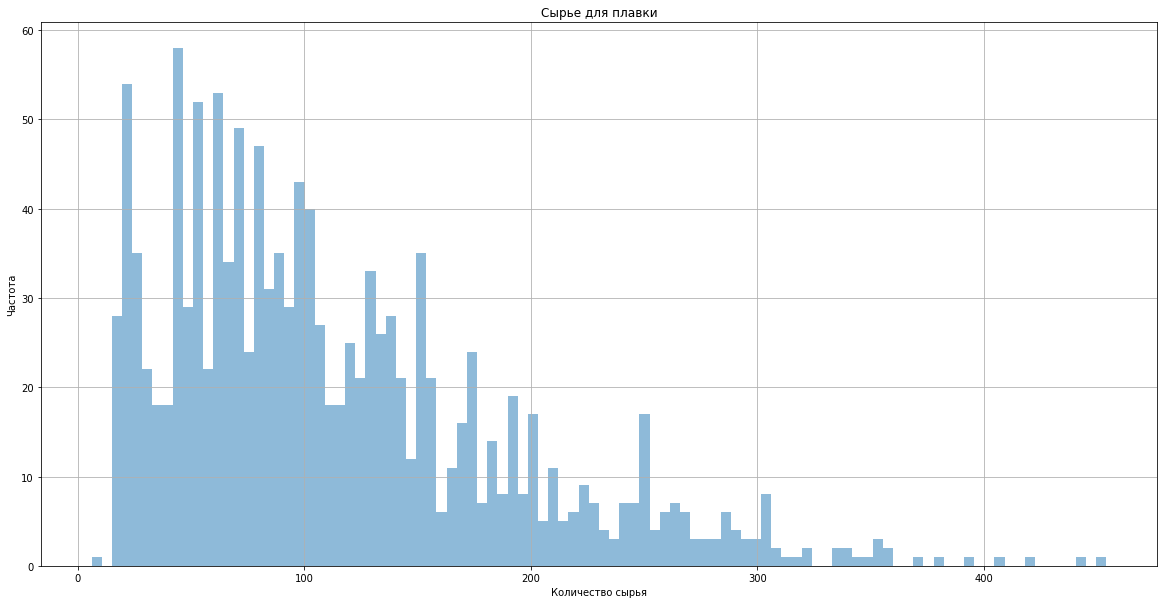

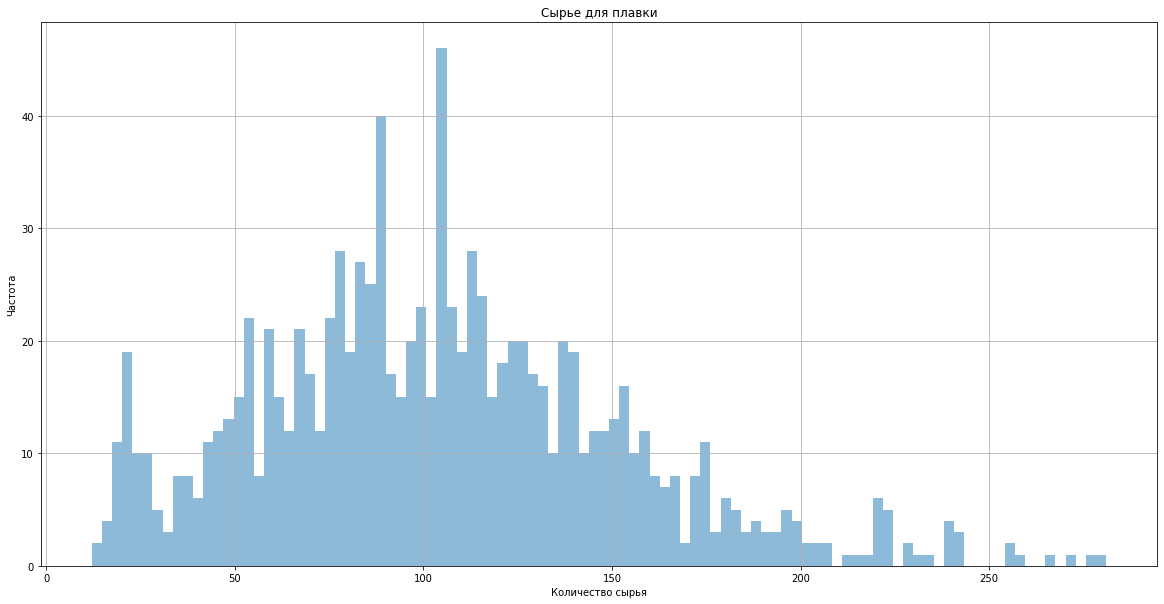

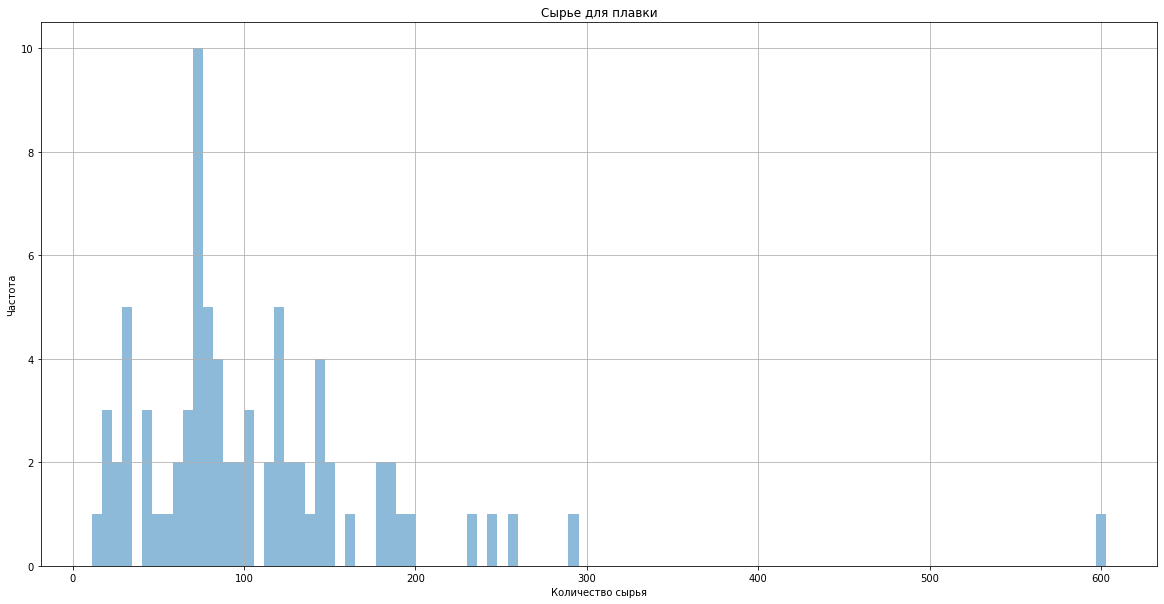

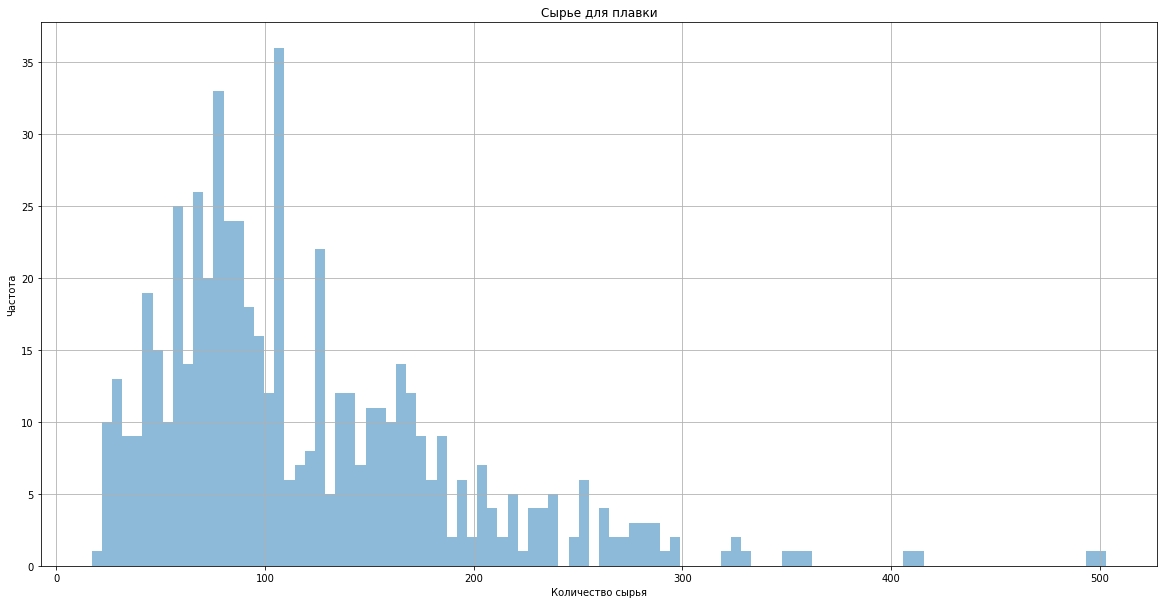

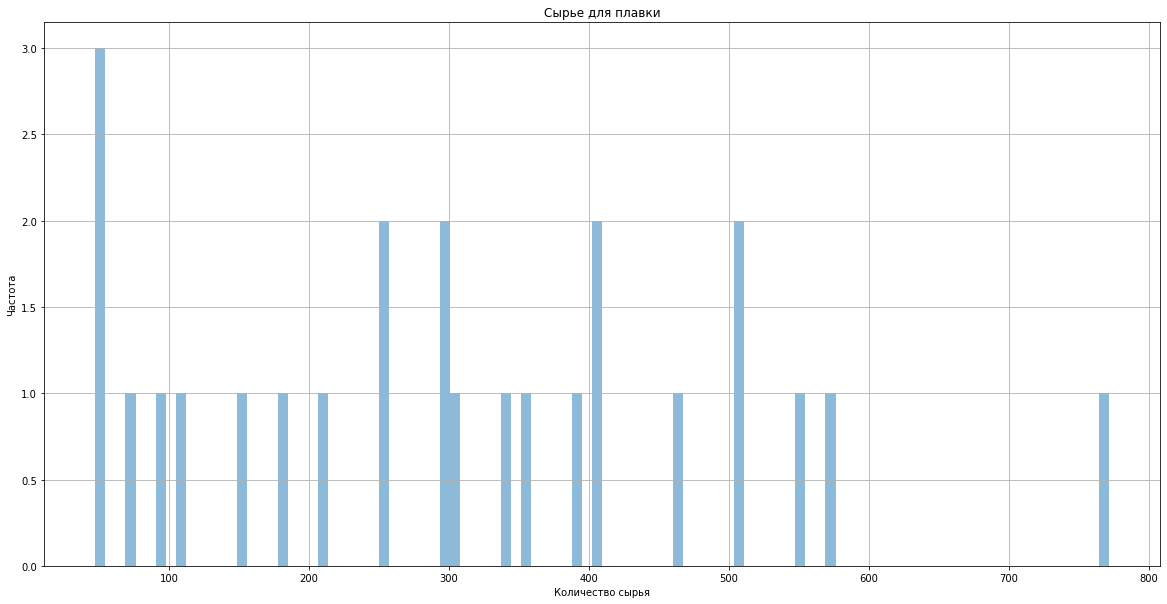

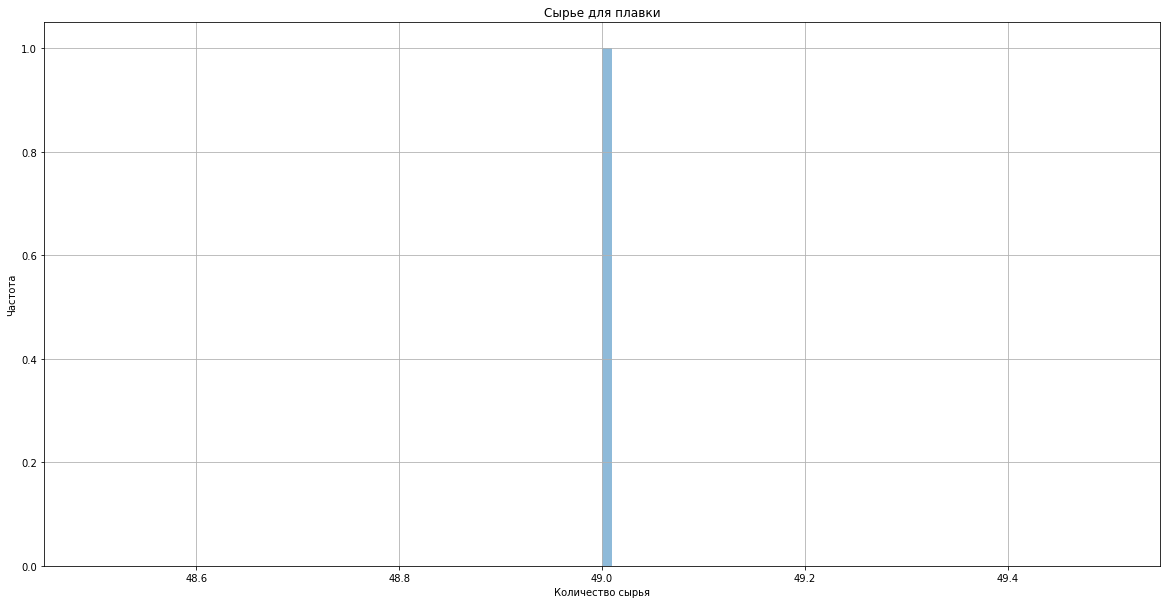

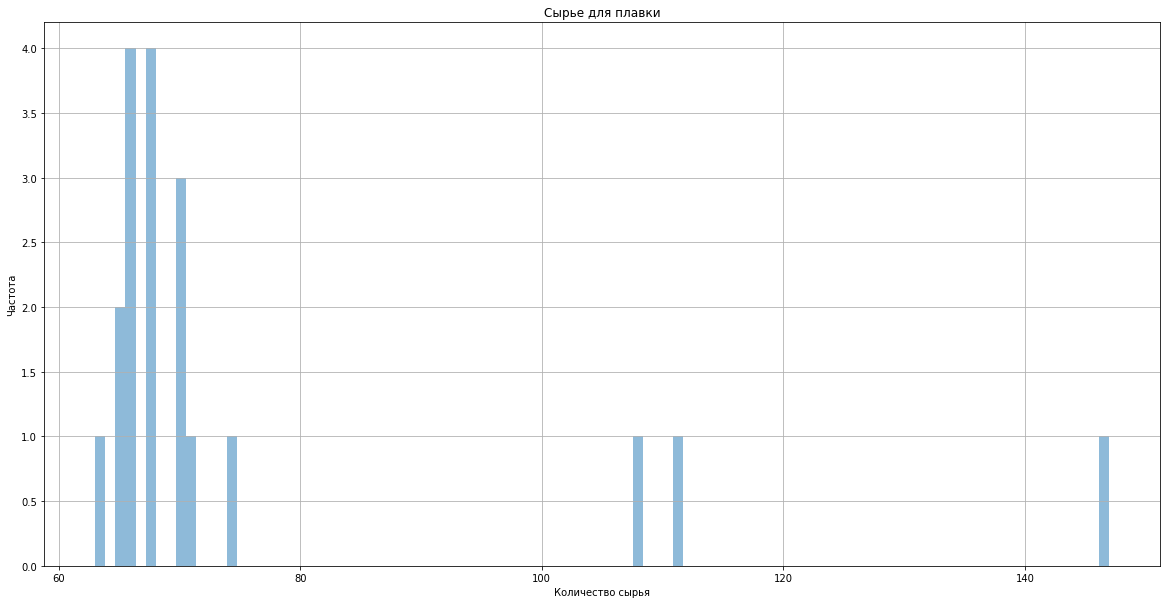

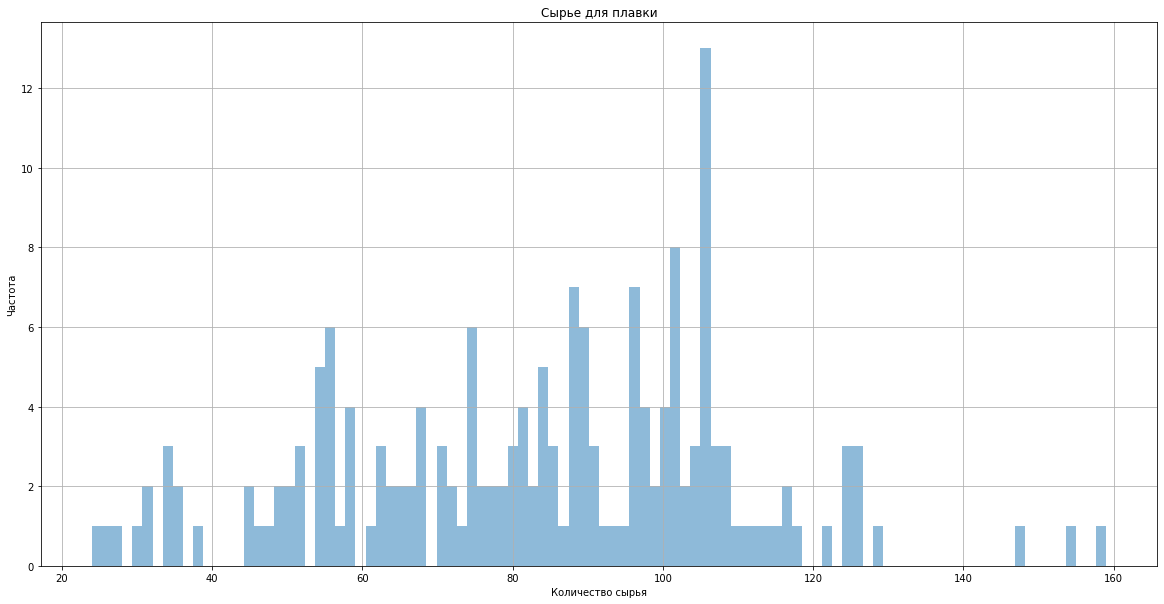

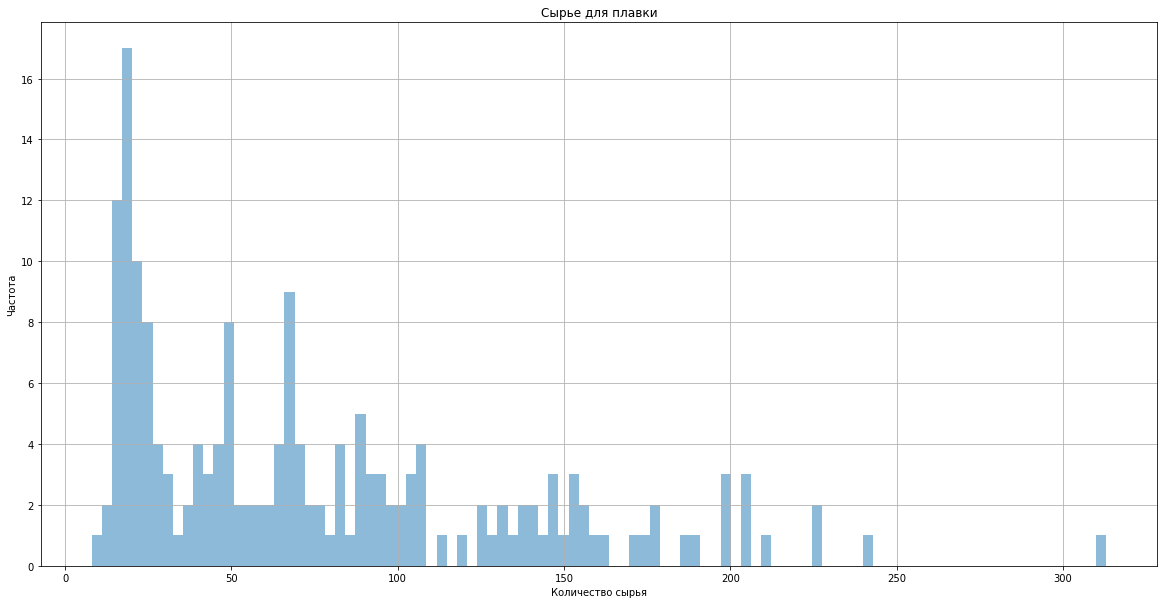

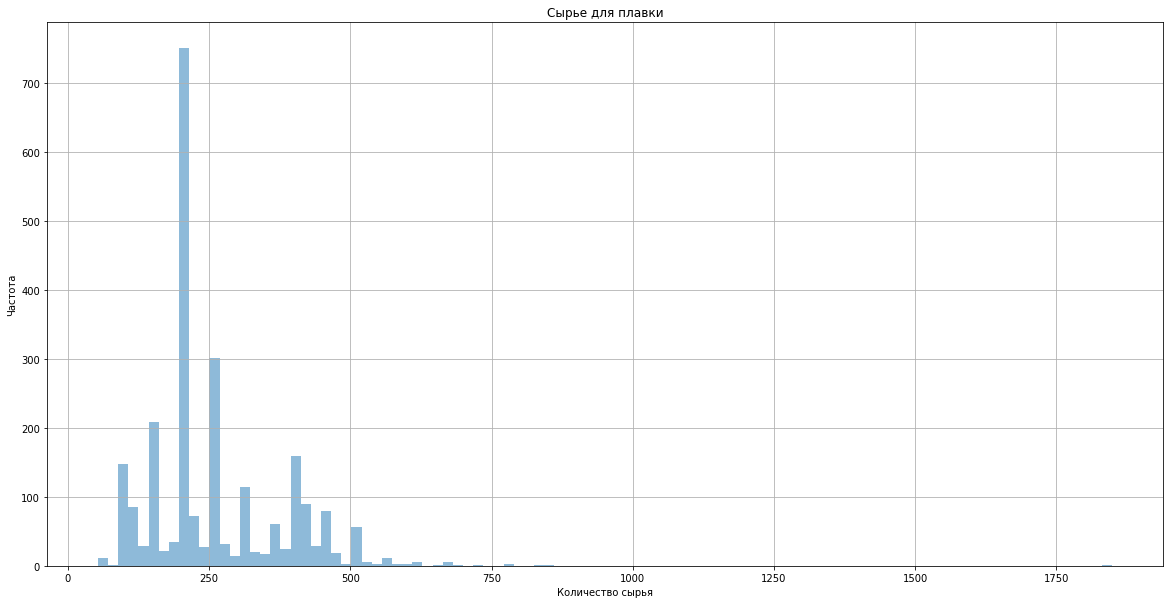

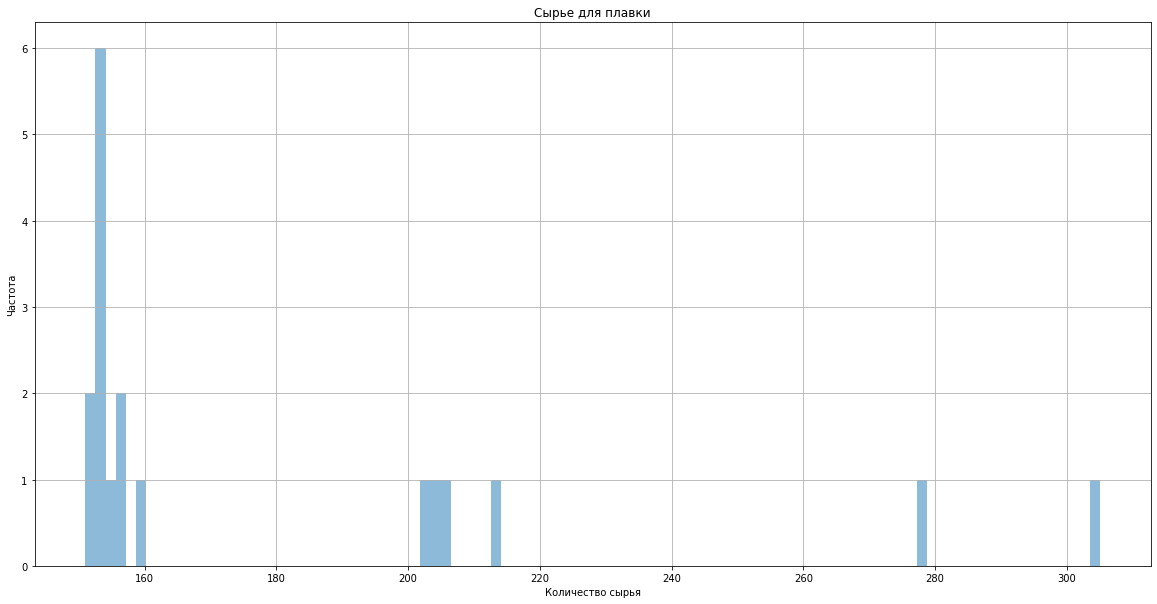

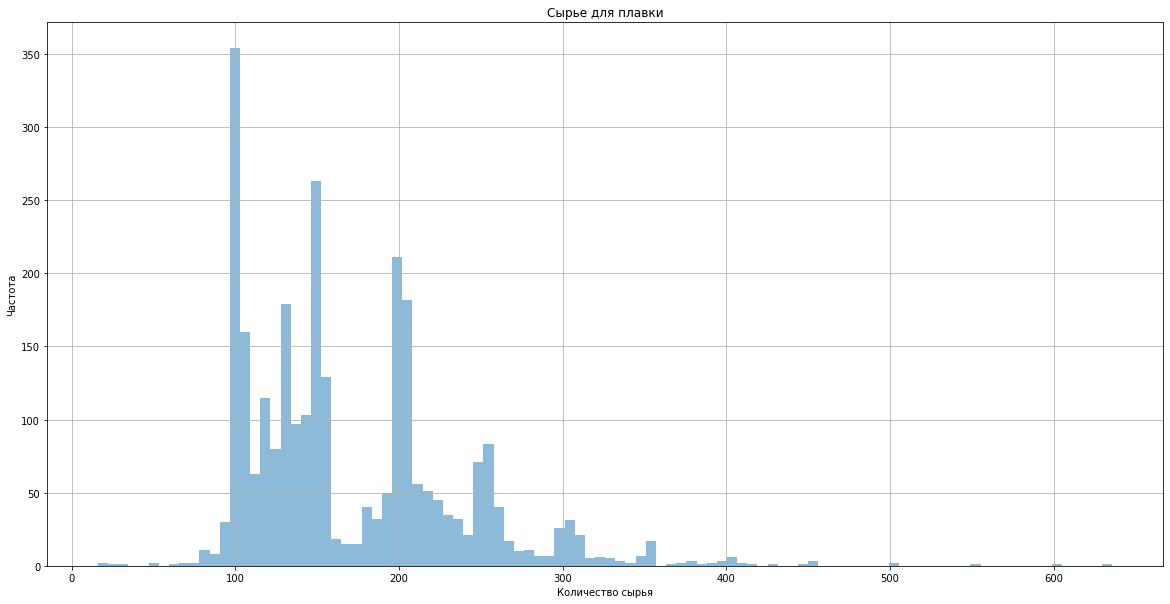

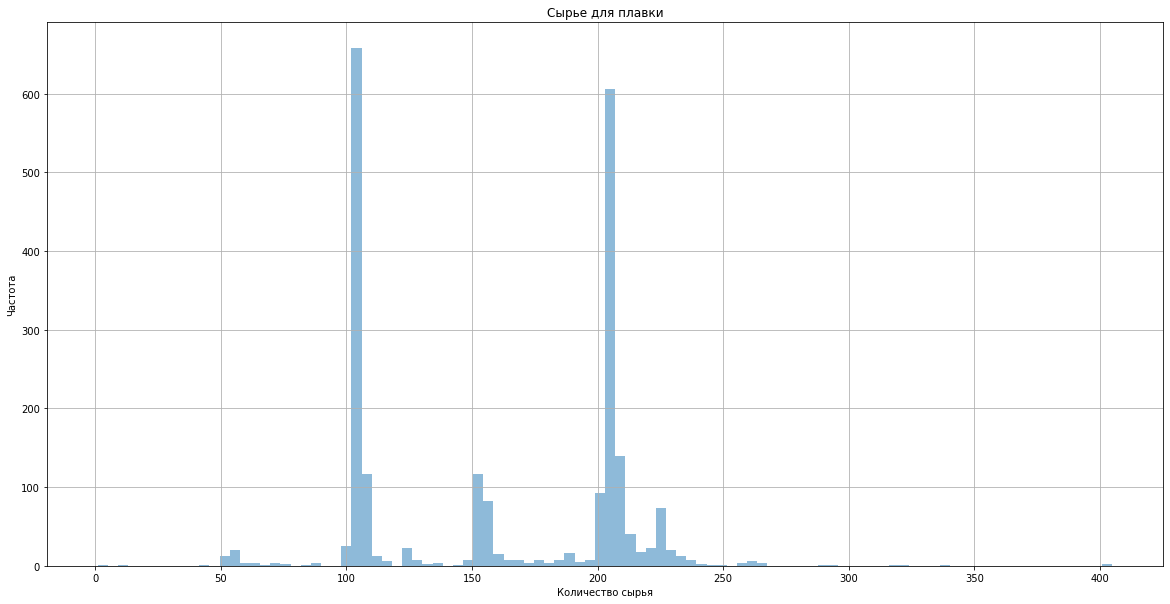

In [20]:
for column in data_bulk.columns:

    data_bulk[column].hist(bins=100, figsize=(20, 10), alpha=0.5)
    
    plt.title('Сырье для плавки')
    
    plt.xlabel('Количество сырья')
    
    plt.ylabel('Частота')
    
    plt.show()

In [21]:
data_bulk_time.head()

,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
key,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,2019-05-03 11:28:48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:24:31,NaN,2019-05-03 11:14:50,2019-05-03 11:10:43
2,NaN,NaN,NaN,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:53:30,NaN,2019-05-03 11:48:37,2019-05-03 11:44:39
3,NaN,NaN,NaN,2019-05-03 12:32:39,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:27:13,NaN,2019-05-03 12:21:01,2019-05-03 12:16:16
4,NaN,NaN,NaN,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:58:00,NaN,2019-05-03 12:51:11,2019-05-03 12:46:36
5,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,2019-05-03 13:34:12,2019-05-03 13:30:47


### Conclusion

Judging by the descriptive statistics, everything seems to be in order with the raw materials.
It is noteworthy that there are very wide peaks.
Raw materials may exhibit an irregular flow, if we take into account the presented missing values, one solution may be to fill these values with zero.
As for the raw material handling time, we find a lot of NaN, only four columns seem to be complete.

In [22]:
data_gas.head()

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


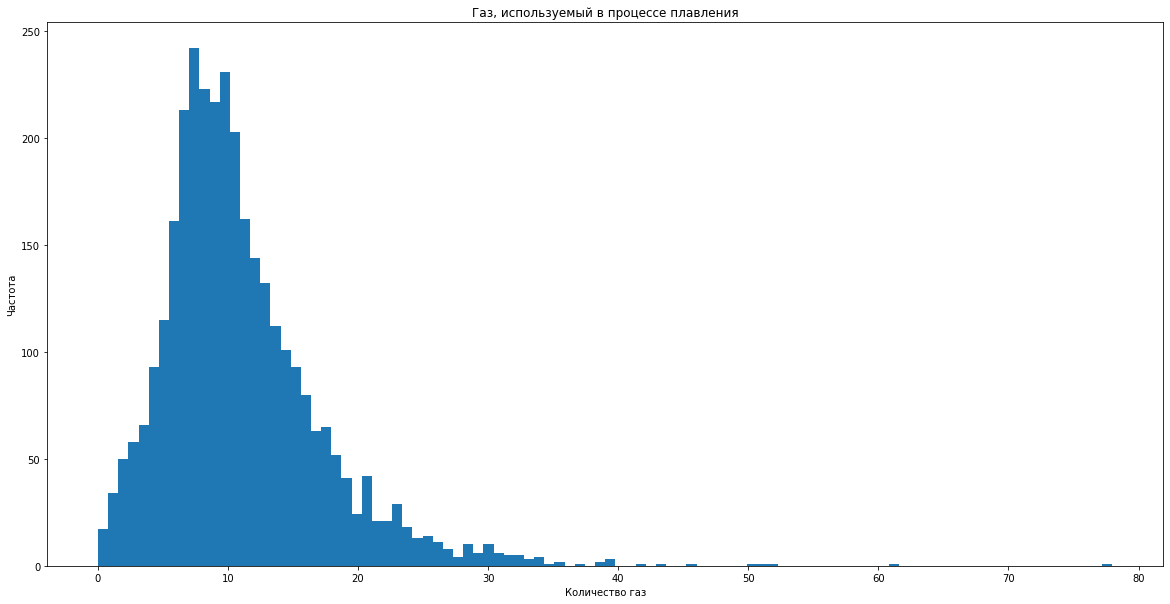

In [23]:
plt.figure(figsize=(20,10))
plt.hist(data_gas['Газ 1'], bins=100)
plt.title('Газ, используемый в процессе плавления')
plt.xlabel('Количество газ')
plt.ylabel('Частота')
plt.show()

In [24]:
data_gas['Газ 1'].describe()

count    3239.000000
mean       11.002062
std         6.220327
min         0.008399
25%         7.043089
50%         9.836267
75%        13.769915
max        77.995040
Name: Газ 1, dtype: float64

In [25]:
data_gas['Газ 1'].isna().sum()

0

### Conclusion

We can assume that with 40 we have atypical values, although out of prudence we are not going to exclude them. Most of the data is in the range from 0 to 30.
Also, we don't have any missing values in this column.

In [26]:
data_temp.head()

,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0


In [27]:
data_temp['Время замера'] = pd.to_datetime(data_temp['Время замера'])

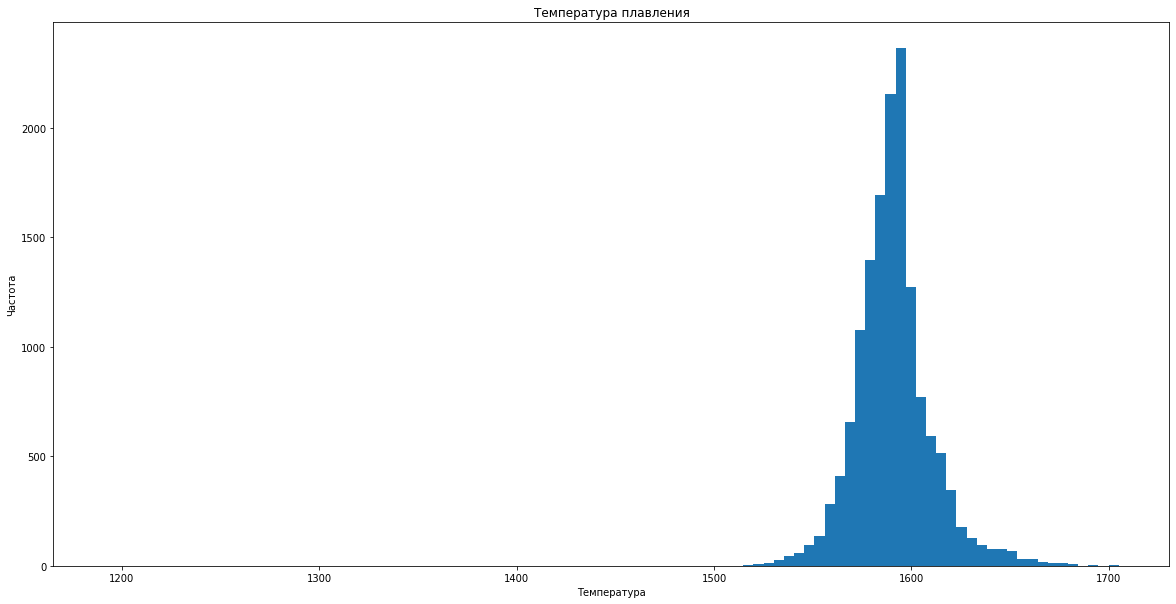

In [28]:
plt.figure(figsize=(20,10))
plt.hist(data_temp['Температура'], bins=100)
plt.title('Температура плавления')
plt.xlabel('Температура')
plt.ylabel('Частота')
plt.show()

In [29]:
data_temp['Температура'].describe()

count    14665.000000
mean      1590.722741
std         20.394381
min       1191.000000
25%       1580.000000
50%       1590.000000
75%       1599.000000
max       1705.000000
Name: Температура, dtype: float64

In [30]:
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   key           18092 non-null  int64         
 1   Время замера  18092 non-null  datetime64[ns]
 2   Температура   14665 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 424.2 KB


### Output

The temperature graph shows the normal distribution with values grouped in the temperature range from 1580 to 1600. In principle, we can say that the values will be easily predictable, which will make our task easier.

In [31]:
data_wire.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


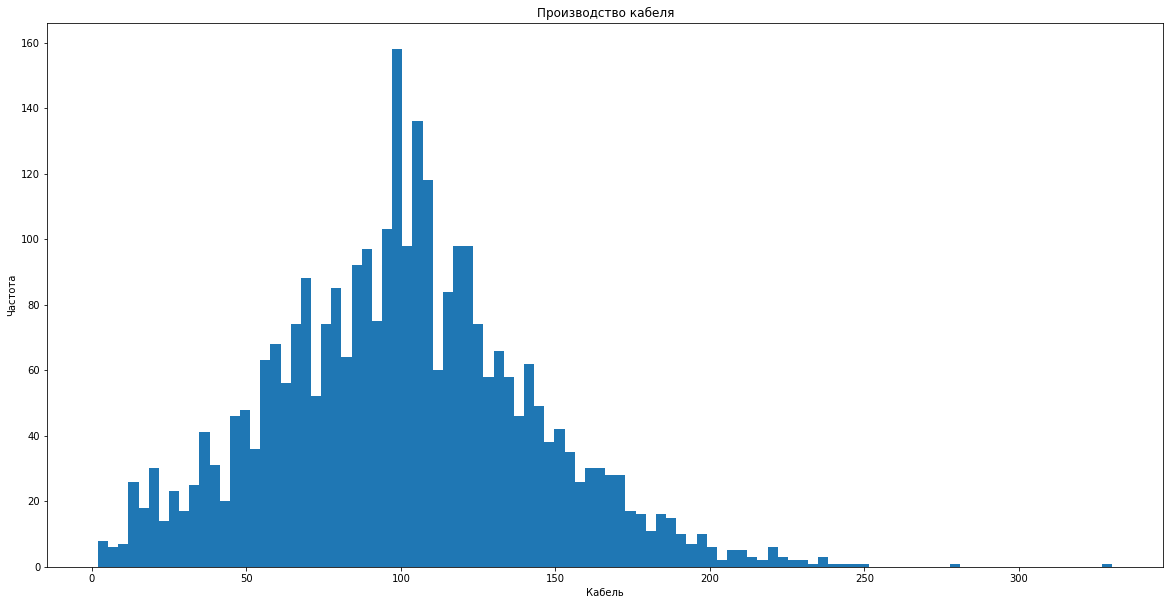

In [32]:
plt.figure(figsize=(20,10))
plt.hist(data_wire['Wire 1'], bins=100)
plt.title('Производство кабеля')
plt.xlabel('Кабель')
plt.ylabel('Частота')
plt.show()

In [33]:
data_wire['Wire 1'].describe()

count    3055.000000
mean      100.895853
std        42.012518
min         1.918800
25%        72.115684
50%       100.158234
75%       126.060483
max       330.314424
Name: Wire 1, dtype: float64

In [34]:
data_wire_time.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:06:19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:11:46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:20:44,2019-05-03 13:15:34,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [35]:
data_wire_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


### Conclusion

The data in the wire columns behave similarly to the bulk columns, in addition, they are also consistent with the fact that both have a large number of missing values.

## General conclusion of EDA

During the preliminary analysis of the data, we found certain anomalies: in data_arc, we continue to delete values less than zero. In data_bulk data_wire we find a lot of missing values that may be caused by a lack of material in these processes. One way to solve this problem may be to fill with zeros in such a way that it does not affect the analysis or the construction of a forecasting model.
The gas and temperature variables are presented as normal parameters without missing values, and their graphical form takes the type of a normal distribution, which is a positive fact that will facilitate the implementation of a good forecast.

## Building a model

We prepare the data as a preliminary step to creating a model. We are going to process all the lost data.

In [36]:
data_bulk=data_bulk.fillna(0)

In [37]:
data_bulk.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0
1,2,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0
2,3,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0
3,4,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0
4,5,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0


In [38]:
data_arc.isna().value_counts()

key    Начало нагрева дугой  Конец нагрева дугой  Активная мощность  Реактивная мощность  electrode_duration
False  False                 False                False              False                True                  11661
                                                                                          False                  3214
dtype: int64

In [39]:
data_wire=data_wire.fillna(0)

In [40]:
data_wire.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Now we are going to create a pivot table for summing reactive and active power.

In [41]:
data_arc_sum = pd.pivot_table(data_arc,
                             values=['Активная мощность','Реактивная мощность'],
                             index='key',
                             aggfunc={'Активная мощность': np.sum,
                                      'Реактивная мощность': np.sum})

data_arc_sum.columns = ['sum_active_power','sum_reactive_power']

In [42]:
data_arc_sum.head()

,sum_active_power,sum_reactive_power
key,,
1,3.036730,2.142821
2,2.139408,1.453357
3,4.063641,2.937457
4,2.706489,2.056992
5,2.252950,1.687991


In [43]:
data_temp.head()

,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0


We run a loop to make sure that the initial and final maximum temperatures match their respective key, leaving aside all those that don't match.

In [44]:
keys = []

for key in list(data_temp['key'].unique()):
    
    try:
        if (data_temp[data_temp['key'] == key]['Время замера'].max() < 
            data_arc[data_arc['key'] == key]['Конец нагрева дугой'].max()): 
            keys.append(key)
            
    except:
        keys.append(key)
        
data_temp = data_temp.query('key not in @keys')

We guarantee that there is not a single lost value that we have forgotten about.

In [45]:
data_temp = data_temp.dropna()

We perform another loop in which we check the unique values. If the unique values are less than two, we sum them up. then we exclude those rows in which the value of the key is equal to the value of the iterator.

In [46]:
for i in (data_temp['key'].unique()): 
    if (data_temp['key']==i).sum() < 2:
        data_temp = data_temp[data_temp.key != i]

In [47]:
data_temp_time = data_temp.pivot_table(index=['key'], values=('Температура', 'Время замера'), aggfunc=['first', 'last'])

In [48]:
data_temp_time.head()

first                            last            
           Время замера Температура        Время замера Температура
key                                                                
1   2019-05-03 11:02:04      1571.0 2019-05-03 11:30:38      1613.0
2   2019-05-03 11:34:04      1581.0 2019-05-03 11:55:09      1602.0
3   2019-05-03 12:06:44      1596.0 2019-05-03 12:35:57      1599.0
4   2019-05-03 12:39:27      1601.0 2019-05-03 12:59:47      1625.0
5   2019-05-03 13:11:03      1576.0 2019-05-03 13:36:39      1602.0

In [49]:
data_temp_time.columns = ['begin_time', 'begin_temperature', 'end_time', 'end_temperature']

We generate a table indicating the start time of the temperature and the end time indicating its end temperature.

In [50]:
data_temp_time.head()

,begin_time,begin_temperature,end_time,end_temperature
key,,,,
1,2019-05-03 11:02:04,1571.0,2019-05-03 11:30:38,1613.0
2,2019-05-03 11:34:04,1581.0,2019-05-03 11:55:09,1602.0
3,2019-05-03 12:06:44,1596.0,2019-05-03 12:35:57,1599.0
4,2019-05-03 12:39:27,1601.0,2019-05-03 12:59:47,1625.0
5,2019-05-03 13:11:03,1576.0,2019-05-03 13:36:39,1602.0


We set the key column as the index.

In [51]:
data_bulk = data_bulk.set_index('key')
data_gas = data_gas.set_index('key') 
data_wire = data_wire.set_index('key')

In [52]:
data_arc

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,electrode_duration
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253,NaT
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438,0 days 00:26:23
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460,0 days 00:19:04
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979,0 days 00:25:25
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691,0 days 00:18:13
...,...,...,...,...,...,...
14871,3241,2019-09-06 16:49:05,2019-09-06 16:51:42,0.439735,0.299579,NaT
14872,3241,2019-09-06 16:55:11,2019-09-06 16:58:11,0.646498,0.458240,NaT
14873,3241,2019-09-06 17:06:48,2019-09-06 17:09:52,1.039726,0.769302,NaT
14874,3241,2019-09-06 17:21:58,2019-09-06 17:22:55,0.530267,0.361543,NaT


We combine different tables into one.

In [53]:
# Perform internal merging of indexes of all data frames
data = pd.concat([data_temp_time, data_arc_sum, data_arc, data_bulk, data_gas, data_wire], axis=1, join='inner')

In [54]:
# Reset the index of the merged data frame

data = data.reset_index(drop=True)

In [55]:
data.head()

,begin_time,begin_temperature,end_time,end_temperature,sum_active_power,sum_reactive_power,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,...,Газ 1,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,2019-05-03 11:02:04,1571.0,2019-05-03 11:30:38,1613.0,3.036730,2.142821,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,...,29.749986,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2019-05-03 11:34:04,1581.0,2019-05-03 11:55:09,1602.0,2.139408,1.453357,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,...,12.555561,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2019-05-03 12:06:44,1596.0,2019-05-03 12:35:57,1599.0,4.063641,2.937457,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,...,28.554793,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2019-05-03 12:39:27,1601.0,2019-05-03 12:59:47,1625.0,2.706489,2.056992,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,...,18.841219,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2019-05-03 13:11:03,1576.0,2019-05-03 13:36:39,1602.0,2.252950,1.687991,2,2019-05-03 11:34:14,2019-05-03 11:36:31,0.381124,...,5.413692,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [56]:
data

,begin_time,begin_temperature,end_time,end_temperature,sum_active_power,sum_reactive_power,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,...,Газ 1,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,2019-05-03 11:02:04,1571.0,2019-05-03 11:30:38,1613.0,3.036730,2.142821,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,...,29.749986,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2019-05-03 11:34:04,1581.0,2019-05-03 11:55:09,1602.0,2.139408,1.453357,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,...,12.555561,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2019-05-03 12:06:44,1596.0,2019-05-03 12:35:57,1599.0,4.063641,2.937457,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,...,28.554793,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2019-05-03 12:39:27,1601.0,2019-05-03 12:59:47,1625.0,2.706489,2.056992,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,...,18.841219,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2019-05-03 13:11:03,1576.0,2019-05-03 13:36:39,1602.0,2.252950,1.687991,2,2019-05-03 11:34:14,2019-05-03 11:36:31,0.381124,...,5.413692,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2324,2019-08-10 11:27:47,1570.0,2019-08-10 11:50:47,1591.0,3.168133,2.210936,541,2019-05-24 00:24:03,2019-05-24 00:28:35,1.107216,...,7.125735,89.150879,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2325,2019-08-10 11:56:48,1554.0,2019-08-10 12:25:13,1591.0,4.174918,2.872031,541,2019-05-24 00:31:50,2019-05-24 00:34:57,0.468234,...,9.412616,114.179527,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2326,2019-08-10 12:37:26,1571.0,2019-08-10 12:53:28,1589.0,3.605239,2.452092,541,2019-05-24 00:45:15,2019-05-24 00:48:06,0.619386,...,6.271699,94.086723,9.04800,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2327,2019-08-10 12:58:11,1591.0,2019-08-10 13:23:31,1594.0,3.202310,2.239820,541,2019-05-24 01:02:37,2019-05-24 01:04:15,0.594044,...,14.953657,118.110717,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [57]:
# Calculate the heating duration (heat_duration) by subtracting the initial time (begin_time) 
# from the end time (end_time)

data['heat_duration'] = data['end_time'] - data['begin_time']





In [58]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2329 entries, 0 to 2328
Data columns (total 38 columns):
 #   Column                Non-Null Count  Dtype          
---  ------                --------------  -----          
 0   begin_time            2329 non-null   datetime64[ns] 
 1   begin_temperature     2329 non-null   float64        
 2   end_time              2329 non-null   datetime64[ns] 
 3   end_temperature       2329 non-null   float64        
 4   sum_active_power      2329 non-null   float64        
 5   sum_reactive_power    2329 non-null   float64        
 6   key                   2329 non-null   int64          
 7   Начало нагрева дугой  2329 non-null   datetime64[ns] 
 8   Конец нагрева дугой   2329 non-null   datetime64[ns] 
 9   Активная мощность     2329 non-null   float64        
 10  Реактивная мощность   2329 non-null   float64        
 11  electrode_duration    2329 non-null   timedelta64[ns]
 12  Bulk 1                2329 non-null   float64        
 13  Bul

We delete columns that have no informational value.

In [59]:
data = data.drop('begin_time',axis=1)
data = data.drop('end_time',axis=1)
data = data.dropna(subset=['end_temperature'])

In [60]:
data.head()

,begin_temperature,end_temperature,sum_active_power,sum_reactive_power,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,electrode_duration,...,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9,heat_duration
0,1571.0,1613.0,3.036730,2.142821,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438,0 days 00:26:23,...,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0 days 00:28:34
1,1581.0,1602.0,2.139408,1.453357,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460,0 days 00:19:04,...,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0 days 00:21:05
2,1596.0,1599.0,4.063641,2.937457,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979,0 days 00:25:25,...,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0 days 00:29:13
3,1601.0,1625.0,2.706489,2.056992,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691,0 days 00:18:13,...,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0 days 00:20:20
4,1576.0,1602.0,2.252950,1.687991,2,2019-05-03 11:34:14,2019-05-03 11:36:31,0.381124,0.220351,0 days 00:22:42,...,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0 days 00:25:36


Мы меняем типы данных на правильные.

In [61]:
data['Газ 1']=data['Газ 1'].astype(int)
data['end_temperature']=data['end_temperature'].astype(int)
data['sum_active_power']=data['sum_active_power'].astype(int)
data['sum_reactive_power']=data['sum_reactive_power'].astype(int)
data['begin_temperature']=data['begin_temperature'].astype(int)
data['heat_duration']=data['heat_duration'].astype(int)
data['electrode_duration']=data['electrode_duration'].astype(int)
for i in range(4,16):
    data[f'Bulk {i}'] = data[f'Bulk {i}'].astype(int)
for i in range(1,10):
    data[f'Wire {i}'] = data[f'Wire {i}'].astype(int)

In [62]:
data = data.drop(['Bulk 1', 'Bulk 2', 'Bulk 3', 'Bulk 5', 'Bulk 6'], axis=1)
data = data.drop(['Wire 3', 'Wire 5', 'Wire 6', 'Wire 7', 'Wire 8', 'Wire 9'], axis=1)

In [63]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2329 entries, 0 to 2328
Data columns (total 25 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   begin_temperature     2329 non-null   int64         
 1   end_temperature       2329 non-null   int64         
 2   sum_active_power      2329 non-null   int64         
 3   sum_reactive_power    2329 non-null   int64         
 4   key                   2329 non-null   int64         
 5   Начало нагрева дугой  2329 non-null   datetime64[ns]
 6   Конец нагрева дугой   2329 non-null   datetime64[ns]
 7   Активная мощность     2329 non-null   float64       
 8   Реактивная мощность   2329 non-null   float64       
 9   electrode_duration    2329 non-null   int64         
 10  Bulk 4                2329 non-null   int64         
 11  Bulk 7                2329 non-null   int64         
 12  Bulk 8                2329 non-null   int64         
 13  Bulk 9            

We calculate correlations for different columns and visualize them using a heat map.

In [64]:
pd.set_option('display.max_columns', None)

numeric_col = data.columns.values.tolist()

corr = data.loc[:,numeric_col].corr()

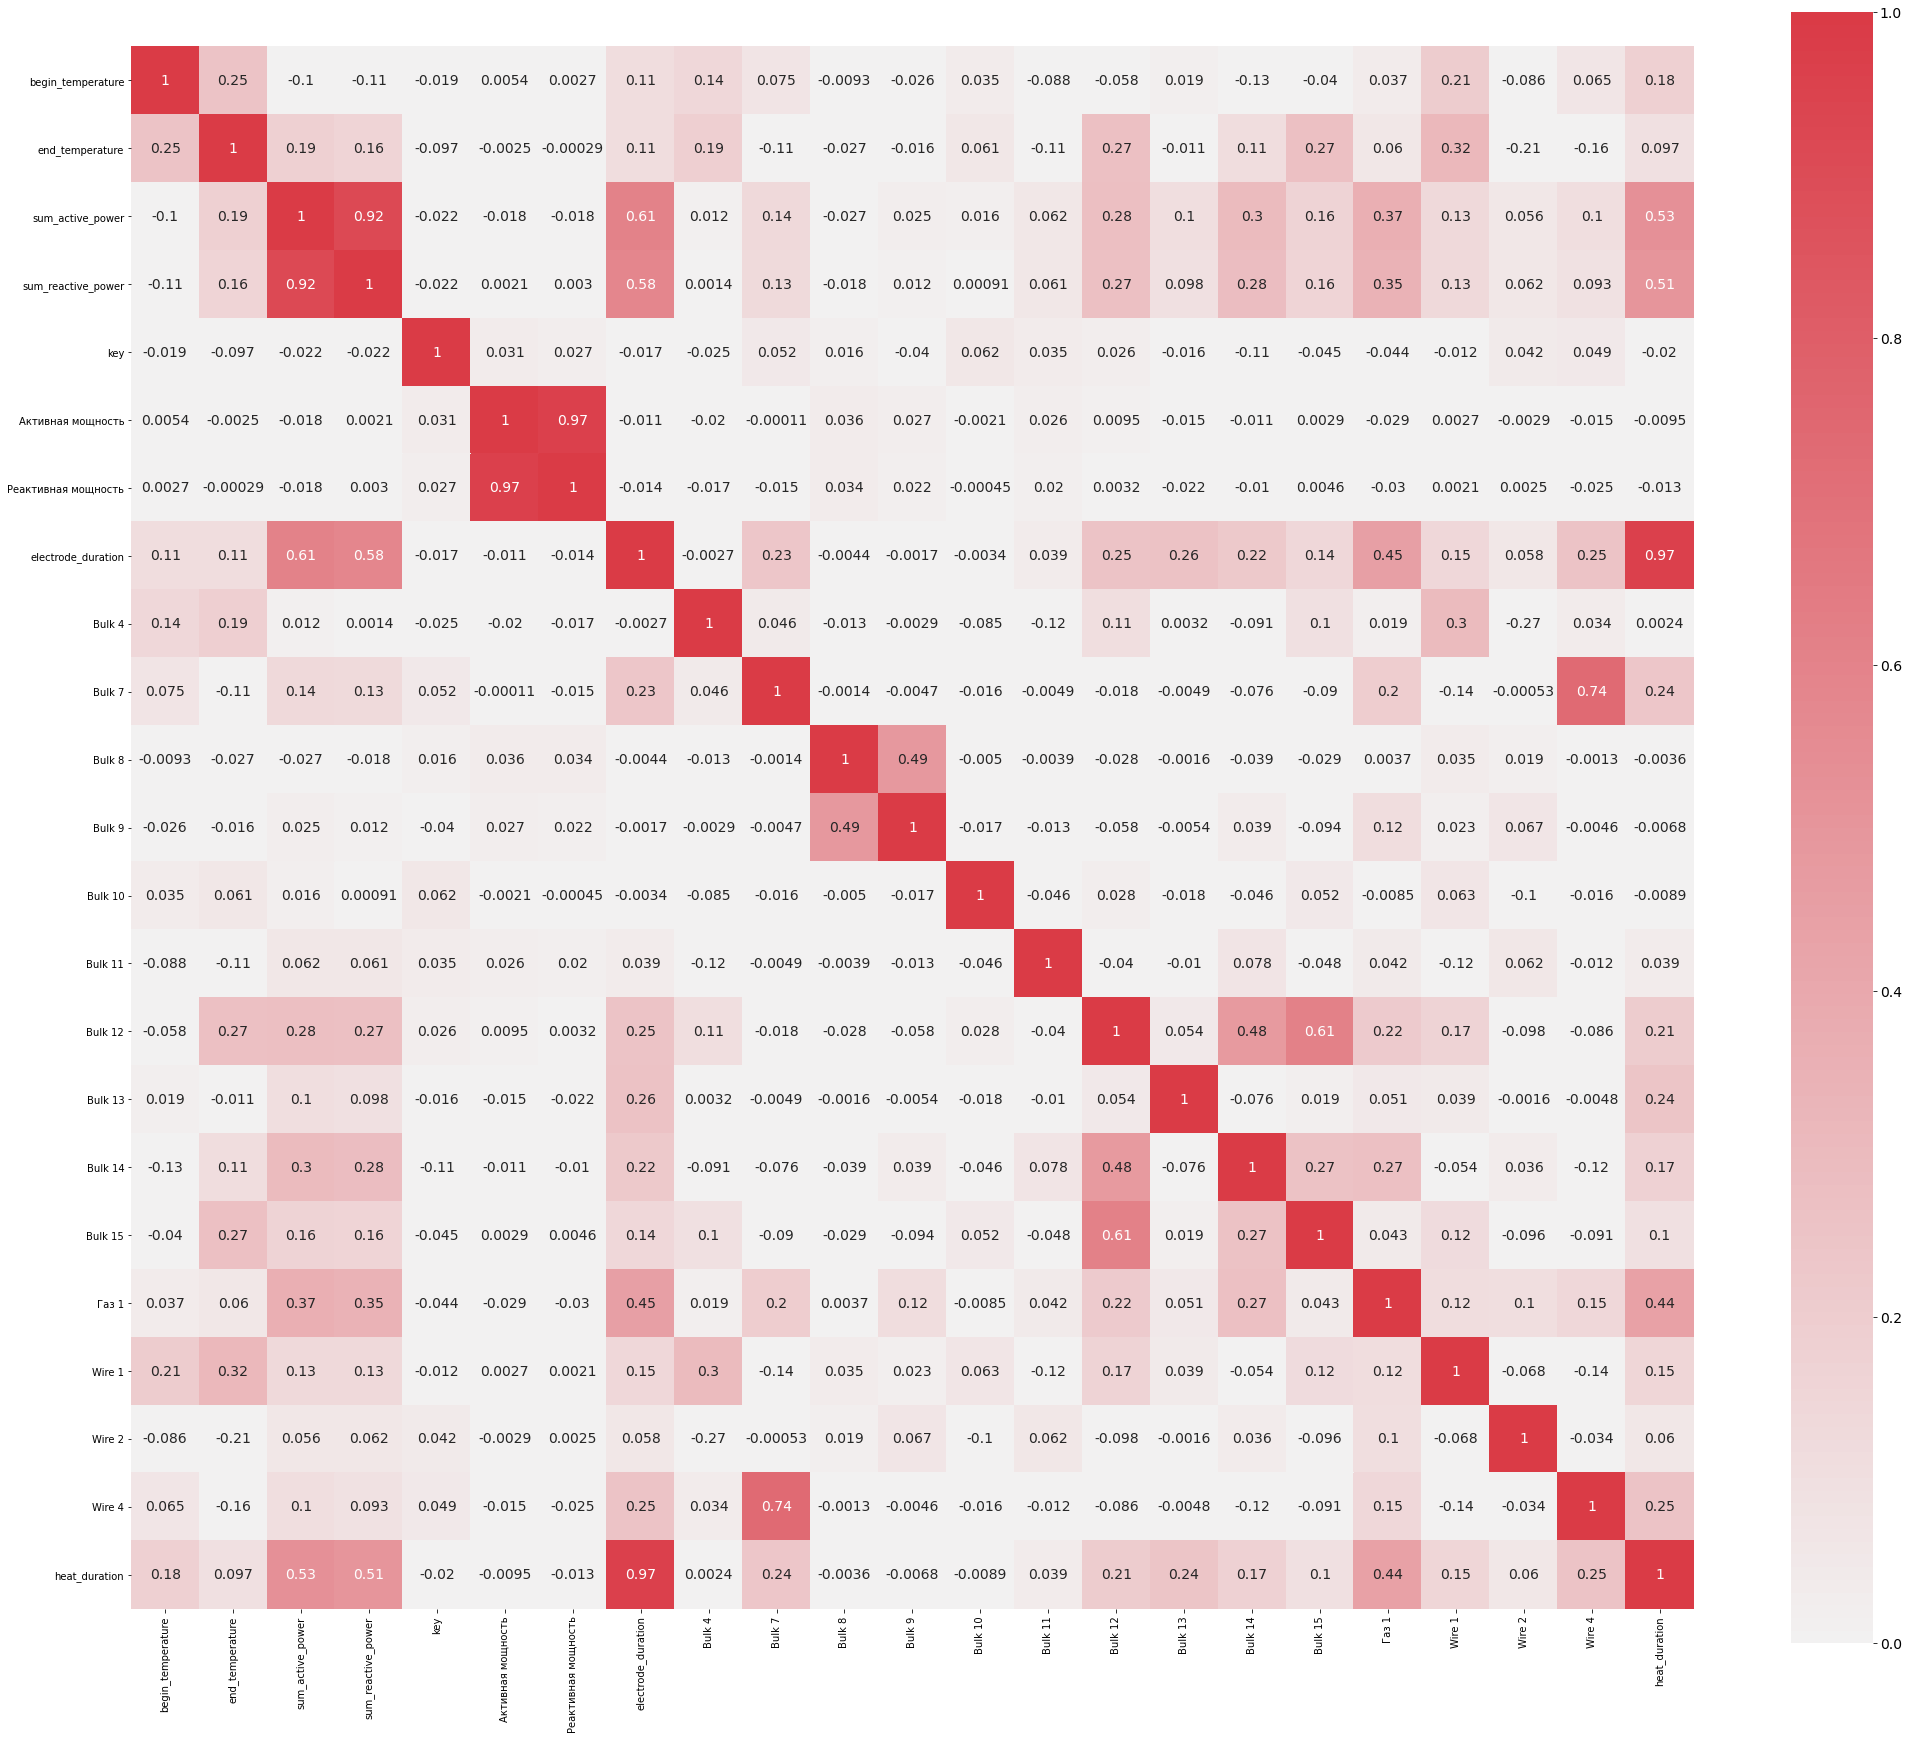

In [65]:
f, ax = plt.subplots(figsize=(35, 30))

font = {'size': 14}

plt.rc('font', **font)

cmap = sns.diverging_palette(220, 10, as_cmap=True)

ax = sns.heatmap(
    corr,         
    cmap=cmap,     
    annot=True,    
    vmax=1,       
    vmin=0,      
    center=0,      
    square=True,   
    linewidths=0, 
    xticklabels=True, yticklabels=True
)

We see a high correlation between Bulk 9 and Wire 8.

We are removing columns that show suspiciously high correlation.

In [66]:
data = data.drop(['Bulk 9', 'sum_reactive_power'], axis=1)
data = data.drop(['Начало нагрева дугой', 'Конец нагрева дугой'], axis=1)

In [67]:
data

,begin_temperature,end_temperature,sum_active_power,key,Активная мощность,Реактивная мощность,electrode_duration,Bulk 4,Bulk 7,Bulk 8,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,Газ 1,Wire 1,Wire 2,Wire 4,heat_duration
0,1571,1613,3,1,0.765658,0.477438,1583000000000,43,0,0,0,0,206,0,150,154,29,60,0,0,1714000000000
1,1581,1602,2,1,0.580313,0.430460,1144000000000,73,0,0,0,0,206,0,149,154,12,96,0,0,1265000000000
2,1596,1599,4,1,0.518496,0.379979,1525000000000,34,0,0,0,0,205,0,152,153,28,91,0,0,1753000000000
3,1601,1625,2,1,0.867133,0.643691,1093000000000,81,0,0,0,0,207,0,153,154,18,89,0,0,1220000000000
4,1576,1602,2,2,0.381124,0.220351,1362000000000,78,0,0,0,0,203,0,151,152,5,89,9,0,1536000000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2324,1570,1591,3,541,1.107216,0.756300,1208000000000,0,0,0,90,0,256,0,129,223,7,89,0,0,1380000000000
2325,1554,1591,4,541,0.468234,0.394713,1569000000000,63,0,0,122,0,256,0,129,226,9,114,0,0,1705000000000
2326,1571,1589,3,541,0.619386,0.452829,824000000000,85,0,0,0,0,230,0,124,226,6,94,9,0,962000000000
2327,1591,1594,3,541,0.594044,0.414143,1358000000000,0,0,0,101,0,206,0,129,207,14,118,0,0,1520000000000


In [68]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2329 entries, 0 to 2328
Data columns (total 21 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   begin_temperature    2329 non-null   int64  
 1   end_temperature      2329 non-null   int64  
 2   sum_active_power     2329 non-null   int64  
 3   key                  2329 non-null   int64  
 4   Активная мощность    2329 non-null   float64
 5   Реактивная мощность  2329 non-null   float64
 6   electrode_duration   2329 non-null   int64  
 7   Bulk 4               2329 non-null   int64  
 8   Bulk 7               2329 non-null   int64  
 9   Bulk 8               2329 non-null   int64  
 10  Bulk 10              2329 non-null   int64  
 11  Bulk 11              2329 non-null   int64  
 12  Bulk 12              2329 non-null   int64  
 13  Bulk 13              2329 non-null   int64  
 14  Bulk 14              2329 non-null   int64  
 15  Bulk 15              2329 non-null   i

We have prepared the data to start predicting the temperature using various models.

In [69]:
# We define a threshold for outliers
temperature_threshold = 1400

# We flag the outliers in the 'end_temperature' column
data['is_outlier'] = data['end_temperature'] < temperature_threshold

# We separate the outliers and non-outliers
outliers = data[data['is_outlier']]
non_outliers = data[~data['is_outlier']]

# We perform our analysis on non-outliers or outliers as needed
# For example, we can calculate the mean temperature for non-outliers:
mean_temperature = non_outliers['end_temperature'].mean()

# We can also analyze the outliers separately if needed
# For example, we can count the number of outliers:
num_outliers = outliers.shape[0]



In [70]:
non_outliers

,begin_temperature,end_temperature,sum_active_power,key,Активная мощность,Реактивная мощность,electrode_duration,Bulk 4,Bulk 7,Bulk 8,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,Газ 1,Wire 1,Wire 2,Wire 4,heat_duration,is_outlier
0,1571,1613,3,1,0.765658,0.477438,1583000000000,43,0,0,0,0,206,0,150,154,29,60,0,0,1714000000000,False
1,1581,1602,2,1,0.580313,0.430460,1144000000000,73,0,0,0,0,206,0,149,154,12,96,0,0,1265000000000,False
2,1596,1599,4,1,0.518496,0.379979,1525000000000,34,0,0,0,0,205,0,152,153,28,91,0,0,1753000000000,False
3,1601,1625,2,1,0.867133,0.643691,1093000000000,81,0,0,0,0,207,0,153,154,18,89,0,0,1220000000000,False
4,1576,1602,2,2,0.381124,0.220351,1362000000000,78,0,0,0,0,203,0,151,152,5,89,9,0,1536000000000,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2324,1570,1591,3,541,1.107216,0.756300,1208000000000,0,0,0,90,0,256,0,129,223,7,89,0,0,1380000000000,False
2325,1554,1591,4,541,0.468234,0.394713,1569000000000,63,0,0,122,0,256,0,129,226,9,114,0,0,1705000000000,False
2326,1571,1589,3,541,0.619386,0.452829,824000000000,85,0,0,0,0,230,0,124,226,6,94,9,0,962000000000,False
2327,1591,1594,3,541,0.594044,0.414143,1358000000000,0,0,0,101,0,206,0,129,207,14,118,0,0,1520000000000,False


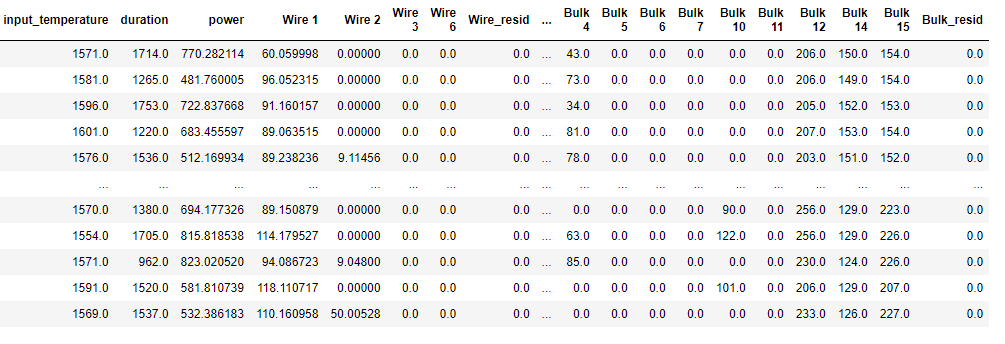

In [71]:
filtered_features = non_outliers

In [73]:
RANDOM_STATE = 120623

In [74]:
# Adding columns 'heating_duration' and 'electrode_duration' to DataFrame filtered_features

filtered_features['heating_duration'] = data['heat_duration']
filtered_features['electrode_duration'] = data['electrode_duration']

features = data.drop('end_temperature', axis=1)
target = data['end_temperature']

Q1 = np.percentile(features, 25, axis=0)
Q3 = np.percentile(features, 75, axis=0)

IQR = Q3 - Q1

upper_bound = Q3 + (4 * IQR)

outliers_mask = (features <= upper_bound).all(axis=1)

filtered_features = features.loc[outliers_mask]
filtered_target = target.loc[outliers_mask]

max_iterations = 2329
iterations = 0

while len(filtered_features) < 2329 and iterations < max_iterations:
    upper_bound += 1
    outliers_mask = (features <= upper_bound).all(axis=1)
    filtered_features = features.loc[outliers_mask]
    filtered_target = target.loc[outliers_mask]
    iterations += 1

filtered_features = filtered_features.reset_index(drop=True)
filtered_target = filtered_target.reset_index(drop=True)

features_train, features_test, target_train, target_test = train_test_split(
    filtered_features,
    filtered_target,
    test_size=0.25,
    random_state=RANDOM_STATE
)

print("Количество оставшихся ведер:", len(filtered_features))


Количество оставшихся ведер: 2310


In [75]:
features_train

,begin_temperature,sum_active_power,key,Активная мощность,Реактивная мощность,electrode_duration,Bulk 4,Bulk 7,Bulk 8,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,Газ 1,Wire 1,Wire 2,Wire 4,heat_duration,is_outlier
1511,1597,2,351,0.854342,0.610435,1589000000000,0,0,0,0,0,106,0,100,104,8,92,43,0,1973000000000,False
482,1582,5,117,0.634296,0.467675,4163000000000,0,0,0,0,0,388,0,214,183,18,149,9,0,4405000000000,False
1734,1569,2,404,0.437197,0.327675,1260000000000,0,0,0,0,0,0,0,257,0,11,119,90,0,1492000000000,False
1939,1580,4,449,0.462798,0.371335,2285000000000,149,0,0,0,0,206,0,98,0,14,100,0,0,2454000000000,False
724,1575,5,170,0.399439,0.306289,3421000000000,0,0,0,0,0,363,0,213,196,12,80,40,0,3840000000000,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,1643,1,47,0.912018,0.659924,1521000000000,0,0,0,0,0,255,0,152,0,11,164,0,0,2152000000000,False
1524,1556,3,353,0.738904,0.523163,1507000000000,0,0,0,0,0,411,0,200,211,9,94,0,0,1674000000000,False
1967,1586,1,455,1.190690,1.025106,657000000000,0,0,0,0,0,155,0,138,107,4,15,0,0,784000000000,False
1149,1615,1,274,0.472830,0.327321,1407000000000,60,0,0,0,0,0,0,0,0,8,202,0,0,1887000000000,False


In [76]:
filtered_features=filtered_features.drop(['key'], axis=1)

In [77]:
filtered_features=filtered_features.drop(['is_outlier'], axis=1)

In [ ]:
filtered_features

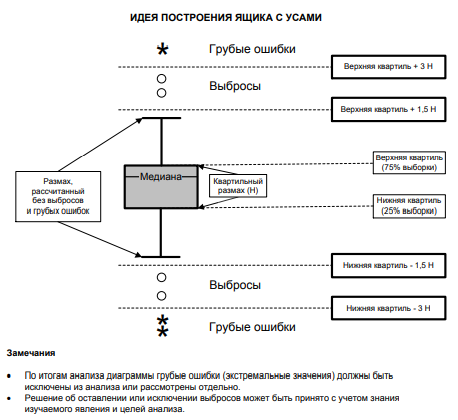

As a first option, we're going to use a random forest to see how it works.

Feature: 0, Score: 0.0
Feature: 1, Score: 4.594636406784184e-05
Feature: 2, Score: 0.0010928064873067201
Feature: 3, Score: 0.007149548962083838
Feature: 4, Score: 0.007191792500710261
Feature: 5, Score: 0.00832285464367263
Feature: 6, Score: 0.009095806336506869
Feature: 7, Score: 0.028162835312845934
Feature: 8, Score: 0.029076102795070495
Feature: 9, Score: 0.040345775234223905
Feature: 10, Score: 0.04446167763922461
Feature: 11, Score: 0.052545703462727834
Feature: 12, Score: 0.054628646227749794
Feature: 13, Score: 0.05549080774975051
Feature: 14, Score: 0.06533780101200384
Feature: 15, Score: 0.07546617016410423
Feature: 16, Score: 0.07928147748965475
Feature: 17, Score: 0.08058511806261762
Feature: 18, Score: 0.08390961218961437
Feature: 19, Score: 0.1280997793663532
Feature: 20, Score: 0.14970973799971082


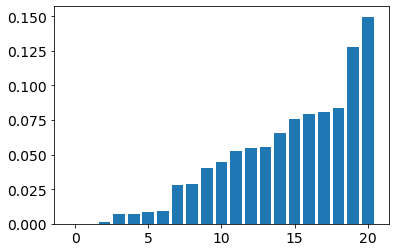

In [78]:
model = RandomForestRegressor() 


model.fit(features_train, target_train)

# getting important functions

importance = model.feature_importances_

importance = np.sort(importance)

# generalizing importance of the function

for i, v in enumerate(importance):
    print('Feature: {}, Score: {}'.format(i, v))
    
# the importance of the object for plotting

plt.bar([x for x in range(len(importance))], importance)
plt.show()

# Setting the threshold value of the importance of the function

threshold = 0.01

# Calculation of average importance for the function

mean_importances = np.mean(importance)

# We create a mask to identify particularly important objects

mask = mean_importances >= threshold

# Convert mask to numeric array

mask = np.array(mask)

# Convert features_train data frame to NumPy array

features_train_array = features_train.to_numpy()

# Selecting the most important objects from the dataset

filtered_features_train = features_train_array[:, mask]

# Changing the shape of the filtered_features_train array

reshaped_features_train = np.reshape(filtered_features_train, (filtered_features_train.shape[0], -1))


In [79]:
reshaped_features_train

array([[1597, 2, 351, ..., 0, 1973000000000, False],
       [1582, 5, 117, ..., 0, 4405000000000, False],
       [1569, 2, 404, ..., 0, 1492000000000, False],
       ...,
       [1586, 1, 455, ..., 0, 784000000000, False],
       [1615, 1, 274, ..., 0, 1887000000000, False],
       [1572, 3, 204, ..., 0, 2308000000000, False]], dtype=object)

******

In [80]:
%%time

model = RandomForestRegressor() 

params = [{'criterion':['mae'],
           'n_estimators':[x for x in range(100, 200, 10)], 
           'random_state':[RANDOM_STATE]}]

clf = GridSearchCV(model, params, scoring='neg_mean_absolute_error', cv=5)

clf.fit(reshaped_features_train, target_train)

means = clf.cv_results_['mean_test_score']

stds = clf.cv_results_['std_test_score']

for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    
    print("%0.4f for %r"% ((mean*-1), params))
    
print()

cv_MAE_RFR = (max(means)*-1)

print()

print("Лучшие параметры")

print()

print(clf.best_params_)


6.8385 for {'criterion': 'mae', 'n_estimators': 100, 'random_state': 120623}
6.8280 for {'criterion': 'mae', 'n_estimators': 110, 'random_state': 120623}
6.8216 for {'criterion': 'mae', 'n_estimators': 120, 'random_state': 120623}
6.8163 for {'criterion': 'mae', 'n_estimators': 130, 'random_state': 120623}
6.8214 for {'criterion': 'mae', 'n_estimators': 140, 'random_state': 120623}
6.8164 for {'criterion': 'mae', 'n_estimators': 150, 'random_state': 120623}
6.8097 for {'criterion': 'mae', 'n_estimators': 160, 'random_state': 120623}
6.8109 for {'criterion': 'mae', 'n_estimators': 170, 'random_state': 120623}
6.8132 for {'criterion': 'mae', 'n_estimators': 180, 'random_state': 120623}
6.8129 for {'criterion': 'mae', 'n_estimators': 190, 'random_state': 120623}


Лучшие параметры

{'criterion': 'mae', 'n_estimators': 160, 'random_state': 120623}
CPU times: user 11min 40s, sys: 1.01 s, total: 11min 41s
Wall time: 11min 42s


The best result is obtained with 100 n_estimators, 6.84. However, we are going to continue testing with other models, such as CatBoostRegressor.

In [81]:
%%time

model = CatBoostRegressor(verbose=False, random_state=RANDOM_STATE)

cv_MAE_CBR = (cross_val_score(model, 
                             reshaped_features_train, 
                             target_train, 
                             cv=5, 
                             scoring='neg_mean_absolute_error').mean() * -1)

print('MAE CatBoostRegressor =', cv_MAE_CBR)

best_params_CBR = CatBoostRegressor(verbose=False, 
                                    random_state=RANDOM_STATE).fit(features_train, 
                                        target_train).get_all_params()


MAE CatBoostRegressor = 6.786942923743267
CPU times: user 16 s, sys: 664 ms, total: 16.6 s
Wall time: 24.1 s


CatBoost gives a slightly better result.

In [82]:
%%time

model = XGBRegressor(random_state=RANDOM_STATE)


params = {
    'n_estimators': [100, 200, 300], 
    'learning_rate': [0.1, 0.01, 0.001],
    'max_depth': [3, 4, 5]
}


clf = RandomizedSearchCV(model, params, scoring='neg_mean_absolute_error', cv=5, n_iter=10)

clf.fit(reshaped_features_train, target_train)

print("Наилучшие параметры для XGBoost:")

print(clf.best_params_)

target_train_pred = clf.predict(reshaped_features_train)

mae_train = mean_absolute_error(target_train, target_train_pred)

print("MAE на тренировочном наборе для XGB: {:.4f}".format(mae_train))

Наилучшие параметры для XGBoost:
{'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.1}
MAE на тренировочном наборе для XGB: 4.9291
CPU times: user 8min 40s, sys: 3.1 s, total: 8min 43s
Wall time: 8min 48s


Scoring with XGBoost is improving.

In [83]:
%%time


model = GradientBoostingRegressor(random_state=RANDOM_STATE)


params = {
    'n_estimators': [100, 200, 300],  
    'learning_rate': [0.1, 0.01, 0.001],
    'max_depth': [3, 4, 5]
}


clf = GridSearchCV(model, params, scoring='neg_mean_absolute_error', cv=5)

clf.fit(reshaped_features_train, target_train)


print("Best parameters for Gradient Boosting:")

print(clf.best_params_)

target_train_pred = clf.predict(reshaped_features_train)

mae_train = mean_absolute_error(target_train, target_train_pred)

print("MAE на тренировочном наборе для Gradient Boosting: {:.4f}".format(mae_train))

Best parameters for Gradient Boosting:
{'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 100}
MAE на тренировочном наборе для Gradient Boosting: 4.6052
CPU times: user 1min 58s, sys: 161 ms, total: 1min 58s
Wall time: 1min 59s


Gradient Boosting gets less as a result than the previous one, that is, the model works better.

In [84]:
%%time

regressor = LGBMRegressor() 

hyperparams = [{'num_leaves':[x for x in range(10,15)], 
                'learning_rate':[0.05, 0.07, 0.9],
                'random_state':[RANDOM_STATE]}]

clf = GridSearchCV(regressor, hyperparams, scoring='neg_mean_absolute_error', cv=5)

clf.fit(reshaped_features_train, target_train)

print("Таблица оценок по набору для разработки:")

print()

means = clf.cv_results_['mean_test_score']

stds = clf.cv_results_['std_test_score']

for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    
    print("%0.4f for %r"% ((mean*-1), params))
    
print()

cv_MAE_LGBMR = (max(means)*-1)

print()

print("Лучшие параметры:")

print()

best_params_LGBMR = clf.best_params_

print(clf.best_params_)
  

Таблица оценок по набору для разработки:

6.7018 for {'learning_rate': 0.05, 'num_leaves': 10, 'random_state': 120623}
6.7137 for {'learning_rate': 0.05, 'num_leaves': 11, 'random_state': 120623}
6.6733 for {'learning_rate': 0.05, 'num_leaves': 12, 'random_state': 120623}
6.6803 for {'learning_rate': 0.05, 'num_leaves': 13, 'random_state': 120623}
6.6932 for {'learning_rate': 0.05, 'num_leaves': 14, 'random_state': 120623}
6.7058 for {'learning_rate': 0.07, 'num_leaves': 10, 'random_state': 120623}
6.6842 for {'learning_rate': 0.07, 'num_leaves': 11, 'random_state': 120623}
6.6800 for {'learning_rate': 0.07, 'num_leaves': 12, 'random_state': 120623}
6.6776 for {'learning_rate': 0.07, 'num_leaves': 13, 'random_state': 120623}
6.7097 for {'learning_rate': 0.07, 'num_leaves': 14, 'random_state': 120623}
8.4433 for {'learning_rate': 0.9, 'num_leaves': 10, 'random_state': 120623}
8.6621 for {'learning_rate': 0.9, 'num_leaves': 11, 'random_state': 120623}
8.4783 for {'learning_rate': 0.9, 'n

The LGBM regressor gets the best score of 6.37.

# Testing the best model

We are moving on to testing the best model at the testing stage.

In [85]:
%%time

params = {
    
    'learning_rate': [0.1],
    'max_depth': [4],
    'n_estimators': [100]
}

model = GradientBoostingRegressor(random_state=RANDOM_STATE)

clf = GridSearchCV(model, params, scoring='neg_mean_absolute_error', cv=5)

clf.fit(reshaped_features_train, target_train)

predictions = clf.predict(features_test)

mae = mean_absolute_error(target_test, predictions)

print("MAE GradientBoostingRegressor на тестовом наборе: ", mae)         


MAE GradientBoostingRegressor на тестовом наборе:  6.959798352005921
CPU times: user 2.64 s, sys: 4.36 ms, total: 2.64 s
Wall time: 2.64 s


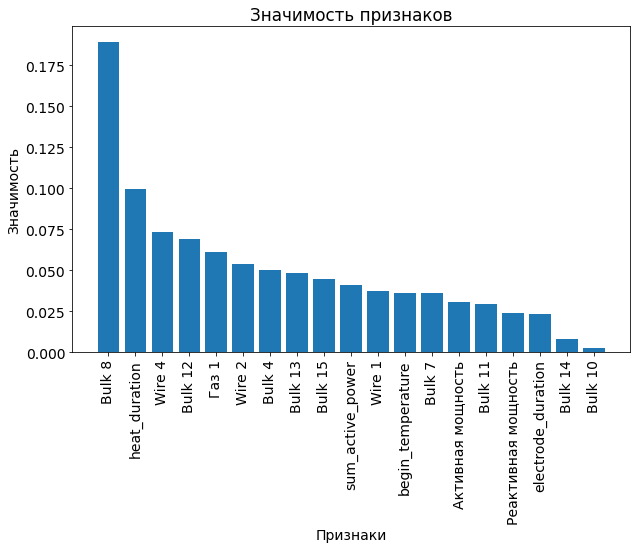

In [87]:
final_model = XGBRegressor(random_state=RANDOM_STATE)

# Training the final model using RandomForestRegressor

final_model.fit(features_train, target_train)

# Calculation of the significance of features

feature_importances = final_model.feature_importances_
feature_importances = feature_importances[:len(filtered_features.columns)]

# Creating a DataFrame to store the significance of features

feature_importances_df = pd.DataFrame({'Признак': filtered_features.columns[:len(feature_importances)],
                                       'Значимость': feature_importances})

# Sorting Data Frame by importance in descending order

feature_importances_df = feature_importances_df.sort_values('Значимость', ascending=False)

# Plotting the significance of features

plt.figure(figsize=(10, 6))
plt.bar(feature_importances_df['Признак'], feature_importances_df['Значимость'])
plt.xlabel('Признаки')
plt.ylabel('Значимость')
plt.title('Значимость признаков')
plt.xticks(rotation=90)
plt.show()


At the testing stage, Gradient Boosting does not meet the necessary requirements.

In [86]:
%%time

params = {
    
    'learning_rate': [0.1],
    'max_depth': [3],
    'n_estimators': [200]
}

model = XGBRegressor(random_state=RANDOM_STATE)

clf = GridSearchCV(model, params, scoring='neg_mean_absolute_error', cv=5)

clf.fit(reshaped_features_train, target_train)

predictions = clf.predict(features_test)

mae = mean_absolute_error(target_test, predictions)

print("MAE XGBRegressor на тестовом наборе: ", mae)         


MAE XGBRegressor на тестовом наборе:  6.806181699759407
CPU times: user 30.6 s, sys: 167 ms, total: 30.8 s
Wall time: 31 s


The model that works best during the testing phase is the XGBRegressor model

### Conclusion
Among the tested models, the one that seemed to fit its functions best was GradientBosstingRegressor, however, with the tested data, it did not seem to meet the requirements, so we had to test the second best model, which was XBGRegressor, than if it had been in the parameters specified by the customer.